In [1]:
from Bio import SeqIO, SearchIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, matthews_corrcoef, plot_confusion_matrix
from scipy.special import expit

In [2]:
def get_domain(path_positives = 'kunitz_noseed.fasta',
               path_negatives = 'notkunitz.fasta',
               type = 'fasta'):
    domain = {}
    for record in SeqIO.parse(path_positives, type):
        record_id = record.id.split('|')[1]
        domain[record_id] = 1
    for record in SeqIO.parse(path_negatives, type):
        record_id = record.id.split('|')[1]
        domain[record_id] = 0
    return domain
domain = get_domain()

In [3]:
def get_evalue_hit(path = 'results_full.out',
                   type = 'hmmer3-tab'):
    results = SearchIO.read(path, type)
    evalue_hit = {}
    for hit in results:
        hit.id = hit.id.split('|')[1]
        evalue_hit[hit.id] = hit.evalue
    return evalue_hit
evalue_hit = get_evalue_hit()

In [4]:
def get_evalue_domain(path = 'results_full.out',
                      type = 'hmmer3-tab'):
    results = SearchIO.read(path, type)
    evalue_domain = {}
    for hit in results: 
        hit.id = hit.id.split('|')[1]
        best_hsp = hit[0]
        evalue_domain[hit.id]= best_hsp.evalue
    return evalue_domain
evalue_domain = get_evalue_domain()

In [5]:
def build_dataset(evalue_hit, evalue_domain, domain):
    dataset = pd.DataFrame({'Evalue hit': evalue_hit,
                            'Evalue best domain': evalue_domain,
                            'Kunitz': domain})
    dataset['Evalue hit'].fillna(10, inplace = True)
    dataset['Evalue best domain'].fillna(10, inplace = True)
    return dataset
dataset = build_dataset(evalue_hit, evalue_domain, domain)
dataset

,Evalue hit,Evalue best domain,Kunitz
Q868Z9,2.500000e-183,3.400000e-16,1
O76840,6.400000e-169,1.000000e-16,1
P84875,5.300000e-61,1.300000e-19,1
Q02445,4.700000e-60,8.500000e-21,1
O54819,1.900000e-58,1.000000e-20,1
...,...,...,...
Q9Z913,1.000000e+01,1.000000e+01,0
O60814,1.000000e+01,1.000000e+01,0
Q79T00,1.000000e+01,1.000000e+01,0
O74098,1.000000e+01,1.000000e+01,0


               evalue          hit
Q868Z9  2.500000e-183       Global
O76840  6.400000e-169       Global
P84875   5.300000e-61       Global
Q02445   4.700000e-60       Global
O54819   1.900000e-58       Global
...               ...          ...
Q9Z913   1.000000e+01  Best domain
O60814   1.000000e+01  Best domain
Q79T00   1.000000e+01  Best domain
O74098   1.000000e+01  Best domain
B1WY30   1.000000e+01  Best domain

[1124472 rows x 2 columns]


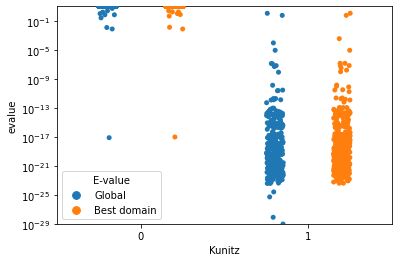

In [22]:
def plot_dataset(dataset):
    evalue_hit = pd.DataFrame({'evalue': dataset['Evalue hit']})
    evalue_hit['hit'] = 'Global'
    evalue_domain = pd.DataFrame({'evalue': dataset['Evalue best domain']})
    evalue_domain['hit'] = 'Best domain'
    final = [evalue_hit, evalue_domain]
    final = pd.concat(final)
    print(final)
    plot = sns.stripplot(y =final.evalue, x=dataset.Kunitz, hue = final.hit, dodge=True, data=dataset)
    plot.set(yscale='log', ylim=(10e-30,10))
    legend = plot.get_legend()
    legend.set_title('E-value')
    plt.savefig("whole_plot.png")
    return plot
plot_dataset(dataset)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Evalue best domain'], 
                                                    dataset['Kunitz'], 
                                                    test_size=0.5, 
                                                    random_state=42)

In [8]:
def train_model(X, y):
    y_true = y
    mcc_list = []
    for i in np.arange(-10, 1, 0.5):
        y_pred = X.apply(lambda x: 1 if x <10**(i) else 0)
        mcc_i = matthews_corrcoef(y_true, y_pred)
        mcc_list.append((i, mcc_i))
        print('E-value = 10e', i, ' MCC: ', mcc_i, sep = '')
        y_pred = y_pred.iloc[0:0]
    best_evalue_list = []
    best_mcc = mcc_list[0][1]
    for record in mcc_list:
        mcc = record[1]
        if mcc > best_mcc:
            best_evalue_list.clear()
            best_evalue_list.append(record[0])
            best_mcc = mcc
        elif mcc == best_mcc:
            best_evalue_list.append(record[0])
    best_evalue = np.mean(best_evalue_list) 
    print('Best E-value is:', 10**best_evalue)
    return 10**best_evalue


In [9]:
threshold = train_model(X_train, y_train)

E-value = 10e-10.0 MCC: 0.9726842049740586
E-value = 10e-9.5 MCC: 0.9726842049740586
E-value = 10e-9.0 MCC: 0.9726842049740586
E-value = 10e-8.5 MCC: 0.9726842049740586
E-value = 10e-8.0 MCC: 0.9757589832666786
E-value = 10e-7.5 MCC: 0.978824126064465
E-value = 10e-7.0 MCC: 0.9849258646212729
E-value = 10e-6.5 MCC: 0.9879626366380753
E-value = 10e-6.0 MCC: 0.9879626366380753
E-value = 10e-5.5 MCC: 0.9879626366380753
E-value = 10e-5.0 MCC: 0.99099012573506
E-value = 10e-4.5 MCC: 0.99099012573506
E-value = 10e-4.0 MCC: 0.99099012573506
E-value = 10e-3.5 MCC: 0.99099012573506
E-value = 10e-3.0 MCC: 0.99099012573506
E-value = 10e-2.5 MCC: 0.99099012573506
E-value = 10e-2.0 MCC: 0.99099012573506
E-value = 10e-1.5 MCC: 0.9880168334167505
E-value = 10e-1.0 MCC: 0.9880168334167505
E-value = 10e-0.5 MCC: 0.9880168334167505
E-value = 10e0.0 MCC: 0.9851933914667453
E-value = 10e0.5 MCC: 0.9824954471700009
Best E-value is: 0.00031622776601683794


In [10]:
plot = plot_dataset(pd.concat([X_train, y_train]))

KeyError: 'Evalue hit'

In [11]:
def test_model(X, y, threshold):
    y_true = y
    y_pred = pd.Series([], dtype = 'category')
    y_pred = X.apply(lambda x: 1 if x < threshold else 0)
    mismatches = y_pred[y_pred != y_true] 
    false_negatives = list(mismatches[mismatches==0].index)
    false_positives = list(mismatches[mismatches==1].index)
    print('False negatives are:', false_negatives)
    print('False positives are:', false_positives)
    graph = sns.stripplot(y = X, x = y)
    graph.set(yscale='log', ylim=(10e-25,10))
    graph.axhline(threshold)
    return confusion_matrix(y_true, y_pred)


False negatives are: ['Q11101']
False positives are: []


array([[280943,      0],
       [     1,    174]])

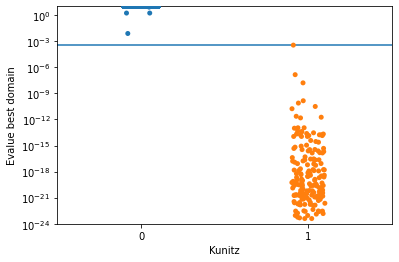

In [12]:
test_model(X_test, y_test, threshold)

<generator object _BaseKFold.split at 0x7f80a809a780>
TRAIN: [     0      1      2 ... 562233 562234 562235] TEST: [     3      9     19 ... 562213 562214 562217]
E-value = 10e-10.0 MCC: 0.9815101673760518
E-value = 10e-9.5 MCC: 0.9833754350903126
E-value = 10e-9.0 MCC: 0.9833754350903126
E-value = 10e-8.5 MCC: 0.9833754350903126
E-value = 10e-8.0 MCC: 0.9852371799275994
E-value = 10e-7.5 MCC: 0.9852371799275994
E-value = 10e-7.0 MCC: 0.9889501805088052
E-value = 10e-6.5 MCC: 0.9908014755561132
E-value = 10e-6.0 MCC: 0.9908014755561132
E-value = 10e-5.5 MCC: 0.9908014755561132
E-value = 10e-5.0 MCC: 0.9926493263380858
E-value = 10e-4.5 MCC: 0.9926493263380858
E-value = 10e-4.0 MCC: 0.9944937520518929
E-value = 10e-3.5 MCC: 0.9944937520518929
E-value = 10e-3.0 MCC: 0.9944937520518929
E-value = 10e-2.5 MCC: 0.9944937520518929
E-value = 10e-2.0 MCC: 0.9926695434342565
E-value = 10e-1.5 MCC: 0.9908553284464356
E-value = 10e-1.0 MCC: 0.9908553284464356
E-value = 10e-0.5 MCC: 0.9890510161581

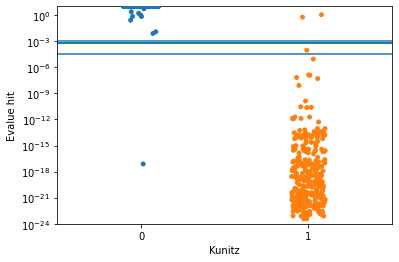

In [13]:
   
    X = dataset['Evalue hit']
    y = dataset['Kunitz']
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_splits = skf.get_n_splits
    print(skf.split(X, y))
    threshold_list = []
    for train_index, test_index in skf.split(X, y):    
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        threshold = train_model(X_train, y_train)
        threshold_list.append(threshold)
        print(test_model(X_test, y_test, threshold))
        average = np.mean(threshold_list)
      

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_frame['Evalue hit'], data_frame['Kunitz'], test_size=0.5)
graph = sns.stripplot(y = X_train, x = y_train)
graph.set(yscale='log', ylim=(10e-30,10))
X_train_np = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
model = LogisticRegression()
model.fit(X_train_np, y_train)
accuracy = model.score(X_test, y_test)
print(model.coef_)
test_confusion = plot_confusion_matrix(model, X_test, y_test)

NameError: name 'data_frame' is not defined